In [1]:
modelPath = "Clickbait"
checkpoint = "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 2                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Hello', ',', '▁how', '▁are', '▁you', '?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['<s>', '▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?', '</s>']
<s> Bonjour, comment ça va?</s>


In [5]:
import datasets as ds

In [6]:
curated = ds.load_from_disk(dataCuratedPath)

In [7]:
curated

Dataset({
    features: ['postText', 'id', 'targetTitle', 'targetDescription', 'truthMean'],
    num_rows: 19538
})

In [8]:
curated.to_pandas()

,postText,id,targetTitle,targetDescription,truthMean
0,UK’s response to modern slavery leaving victim...,858462320779026432,‘Inexcusable’ failures in UK’s response to mod...,“Inexcusable” failures in the UK’s system for ...,1.000000
1,this is good,858421020331560960,Donald Trump Appoints Pro-Life Advocate as Ass...,President Donald Trump has appointed pro-life ...,0.133333
2,"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,The ‘forgotten’ Trump roast: Relive his brutal...,President Trump won't be at this year's White ...,0.400000
3,Meet the happiest #dog in the world!,858323428260139008,"Meet The Happiest Dog In The World, Maru The H...","The article is about Maru, a husky dog who has...",0.266667
4,Tokyo's subway is shut down amid fears over an...,858283602626347008,Tokyo's subway is shut down amid fears over an...,"The temporary suspension, which lasted ten min...",0.000000
...,...,...,...,...,...
19533,Brazil soccer team and pilot's final interview...,804250183642976256,"NBC News Video See Brazil Soccer Team, Pilot’s...",NBC News,0.133333
19534,😱😱😱😱😱😱😱😱😱😱😱😱😱😱,804156272086020096,Politico Scoop: Eric Trump Killed Two Deer,Politico Scoop: Eric Trump Killed Two Deer,0.066667
19535,Frenchs Forest high school may have to make wa...,804149798651588608,Frenchs Forest high school may relocate to mak...,The Forest High School on Sydney's northern be...,0.333333
19536,Oh Jeff… #bruh,804134698729385984,Los Angeles Rams Jeff Fisher May Think Danny W...,"Los Angeles Rams news, rumors, scores, schedul...",0.733333


In [9]:
if modelPath == "ClickbaitTest":
    # La il va falloir filtrer pour Actualités, trucs et astuces
    import re
    pageName = 'Actualités, trucs et astuces'
    p = re.compile(pageName)
    curated=curated.filter(lambda x : p.match(x["Page name"]))

In [10]:
longueur= len(curated)
longueur

19538

In [11]:
trie=sorted(curated[LCfraction])

In [12]:
import matplotlib.pyplot as plt

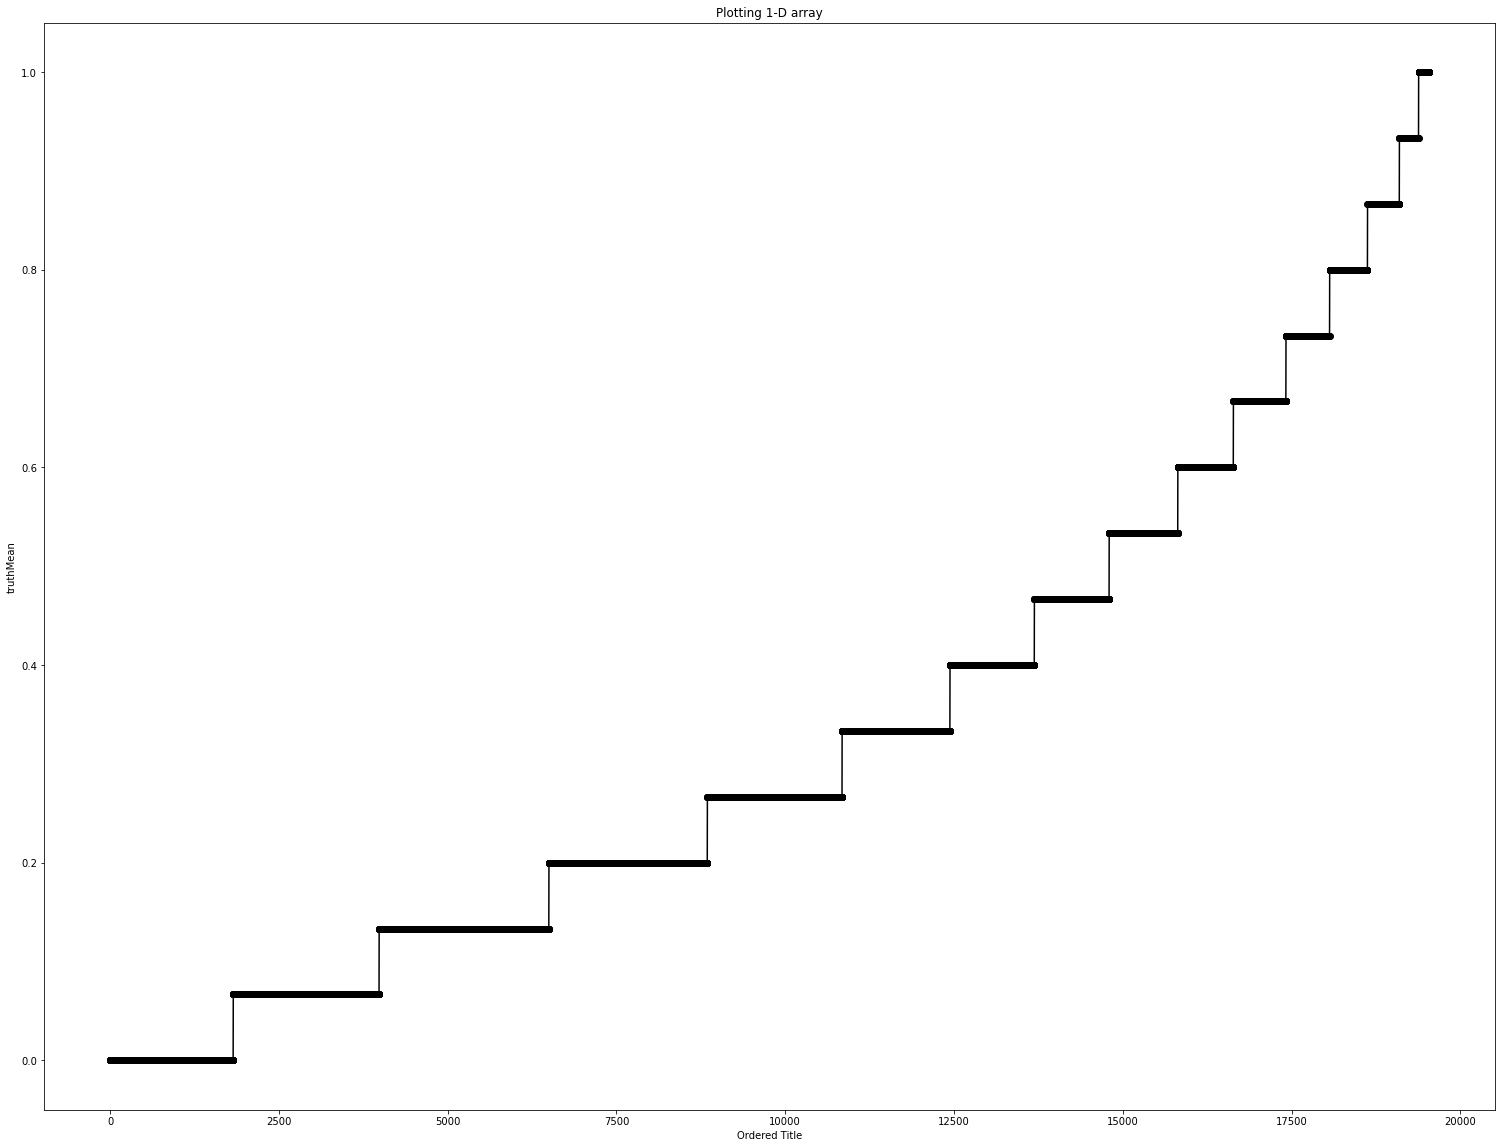

In [13]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [14]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.26666666664]

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )
    fraction = sample[LCfraction]
    
    if num_labels == 1:
        tokenized_sample["label"] = fraction
    else:
        tokenized_sample["label"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["label"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/19538 [00:00<?, ?ex/s]

In [17]:
tokenized_curated.to_pandas().describe()

,id,truthMean,label
count,1.953800e+04,19538.000000,19538.000000
mean,8.314393e+17,0.324530,0.547241
std,1.569423e+16,0.252824,0.497776
min,8.041138e+17,0.000000,0.000000
25%,8.178346e+17,0.133333,0.000000
50%,8.316563e+17,0.266667,1.000000
75%,8.449404e+17,0.466667,1.000000
max,8.584642e+17,1.000000,1.000000


In [18]:
print(tokenized_curated[0:3])

{'postText': ['UK’s response to modern slavery leaving victims destitute while abusers go free', 'this is good', 'The "forgotten" Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club'], 'id': [858462320779026432, 858421020331560960, 858368123753435136], 'targetTitle': ['‘Inexcusable’ failures in UK’s response to modern slavery leaving victims destitute while abusers go free, report warns', 'Donald Trump Appoints Pro-Life Advocate as Assistant Secretary of HHS for Public Affairs', 'The ‘forgotten’ Trump roast: Relive his brutal 2004 thrashing at the New York Friars Club'], 'targetDescription': ['“Inexcusable” failures in the UK’s system for dealing with modern slavery are\xa0leaving victims reduced to destitution while their abusers go free because they are not adequately supported to testify against them, an alarming report has warned.', 'President Donald Trump has appointed pro-life advocate and former president of Americans United for Life Dr. Charmaine Yoest to 

In [19]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [20]:
tokenized_curated2['train'].to_pandas()

,postText,id,targetTitle,targetDescription,truthMean,input_ids,attention_mask,label
0,Does Bonobos make sense?,853365074307813376,Why is Walmart buying up brands?,"Bonobos, by Walmart.",0.266667,"[0, 101790, 10529, 58385, 7, 3249, 10422, 32, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,A former Wall Streeter is now a Master Sommeli...,814153667406336000,This former Wall Streeter is now a Master Somm...,Master Sommelier Andrea Robinson gives advice ...,0.200000,"[0, 62, 36770, 23706, 15130, 56, 83, 5036, 10,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,Warriors learn once again that being the best ...,832764432669302784,Warriors learn once again that being the best ...,The Golden State Warriors shot a bizarre fashi...,0.666667,"[0, 211759, 30698, 24145, 13438, 450, 8035, 70...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,The 5 characters who are most likely die in Th...,847829590680711168,The Walking Dead season 7 finale episode: The ...,This weekend sees the dreaded finale of The Wa...,0.000000,"[0, 581, 190, 124850, 2750, 621, 2684, 47041, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,Northwestern MutualVoice: If we love pensions ...,834304472151109632,Northwestern MutualVoice: If We Love Pensions ...,"Mark Perrault, a Northwestern Mutual wealth ma...",0.000000,"[0, 23924, 1177, 48850, 174948, 289, 36635, 29...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...
15625,17 of the kinkiest things people did in 2016,806009276565192704,17 Times Sex Almost Went Too Fucking Far In 2016,,1.000000,"[0, 729, 111, 70, 200, 22088, 525, 8966, 3395,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
15626,Six children feared dead in Baltimore house fire,819601366725300224,Six children feared dead in Baltimore house fire,A mother and her nine children are caught up i...,0.533333,"[0, 84247, 20020, 30783, 297, 103494, 23, 2300...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
15627,Two young girls critically wounded in separate...,831352277902454784,"Two girls shot in Chicago, critically wounded ...",Police say the two young girls who were critic...,0.266667,"[0, 32964, 27150, 29526, 130306, 538, 148, 167...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
15628,"Toys from ""Stranger Things"" and other Netflix ...",829395541805191168,Netflix wants to start selling you merch,There's no business like toy business.\n,0.200000,"[0, 109451, 7, 1295, 44, 97315, 12060, 119175,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [21]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [22]:
tokenized_curated4 = tokenized_curated3

In [23]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 15630
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 3908
    })
})

In [24]:
#tokenized_curated4.set_format("torch")

In [25]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  # learning_rate = 5e-4,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [28]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[0, 101790, 10529, 58385, 7, 3249, 10422, 32, 2], [0, 62, 36770, 23706, 15130, 56, 83, 5036, 10, 18897, 4961, 27641, 56, 292, 3688, 25, 7, 604, 67660, 100, 6782, 9, 1073, 1916, 108069, 2], [0, 211759, 30698, 24145, 13438, 450, 8035, 70, 2965, 7175, 26950, 70, 47010, 7, 621, 38162, 2], [0, 581, 190, 124850, 2750, 621, 2684, 47041, 68, 23, 581, 167992, 51952, 34003, 361, 22688, 2], [0, 23924, 1177, 48850, 174948, 289, 36635, 2980, 12, 4263, 642, 5161, 23168, 7, 221, 5045, 4, 15400, 54, 642, 35463, 142, 539, 31075, 32, 2], [0, 702, 24092, 7, 398, 765, 10, 4488, 5732, 4032, 292, 3853, 2174, 22027, 25, 18, 12319, 1884, 442, 2], [0, 6470, 930, 5829, 10186, 12, 98809, 25, 7, 43334, 525, 56816, 5809, 186, 100553, 2481, 25, 7, 124498, 525, 15063, 19, 2], [0, 22392, 13038, 44, 70547, 52128, 58, 111, 18405, 1916, 8633, 18, 34695, 237, 5879, 45831, 71985, 2481, 98, 58982, 2], [0, 360, 2343, 232, 214, 34202, 5879, 4, 14431, 2581, 110226, 14, 43264, 83, 141753, 10, 152853, 13, 111, 70

In [29]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [30]:
# faire la boucle avec le trainer pytorch
# %pdb
trainer.train()

***** Running training *****
  Num examples = 15630
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3908


Step,Training Loss,Validation Loss,Accuracy,F1
50,No log,0.689978,0.545803,0.706174
100,No log,0.688948,0.545803,0.706174
150,No log,0.689133,0.545803,0.706174
200,No log,0.689387,0.545803,0.706174
250,No log,0.689563,0.545803,0.706174
300,No log,0.689119,0.545803,0.706174
350,No log,0.689008,0.545803,0.706174
400,No log,0.688955,0.545803,0.706174
450,No log,0.688981,0.545803,0.706174
500,0.689600,0.689090,0.545803,0.706174


***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Click

TrainOutput(global_step=650, training_loss=0.6894203420785757, metrics={'train_runtime': 127.7857, 'train_samples_per_second': 489.257, 'train_steps_per_second': 30.582, 'total_flos': 41438064286080.0, 'train_loss': 0.6894203420785757, 'epoch': 0.67})

In [34]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3908
  Batch size = 16


{'eval_loss': 0.0008608002681285143,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 4.7501,
 'eval_samples_per_second': 822.712,
 'eval_steps_per_second': 51.577,
 'epoch': 0.67}

In [35]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "test" #  "train" # "test"

In [36]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated4[overfitting])

***** Running Prediction *****
  Num examples = 3908
  Batch size = 16


In [37]:
predictions.predictions

array([[ 3.4859664, -3.525416 ],
       [ 3.4859664, -3.525416 ],
       [-3.530679 ,  3.5686157],
       ...,
       [-3.530601 ,  3.5686374],
       [-3.530688 ,  3.5686085],
       [-3.530601 ,  3.5686374]], dtype=float32)

In [38]:
predictions.metrics

{'test_loss': 0.0008608002681285143,
 'test_accuracy': 1.0,
 'test_f1': 1.0,
 'test_runtime': 6.9842,
 'test_samples_per_second': 559.55,
 'test_steps_per_second': 35.079}

In [39]:
tct = tokenized_curated2[overfitting].to_pandas()

In [40]:
if num_labels == 1:
    tct["labelC"] = predictions.predictions
else:
    tct["labelC"] = np.argmax(predictions.predictions, axis=1)   

In [41]:
tct = tct.sort_values(LCfraction)

In [42]:
palette = ["r", "g", "b", "c", "m"]

In [43]:
if num_labels == 1:
    color = [val for val in tct["labelC"]]
else:
    color = [palette[val] for val in tct["labelC"]]

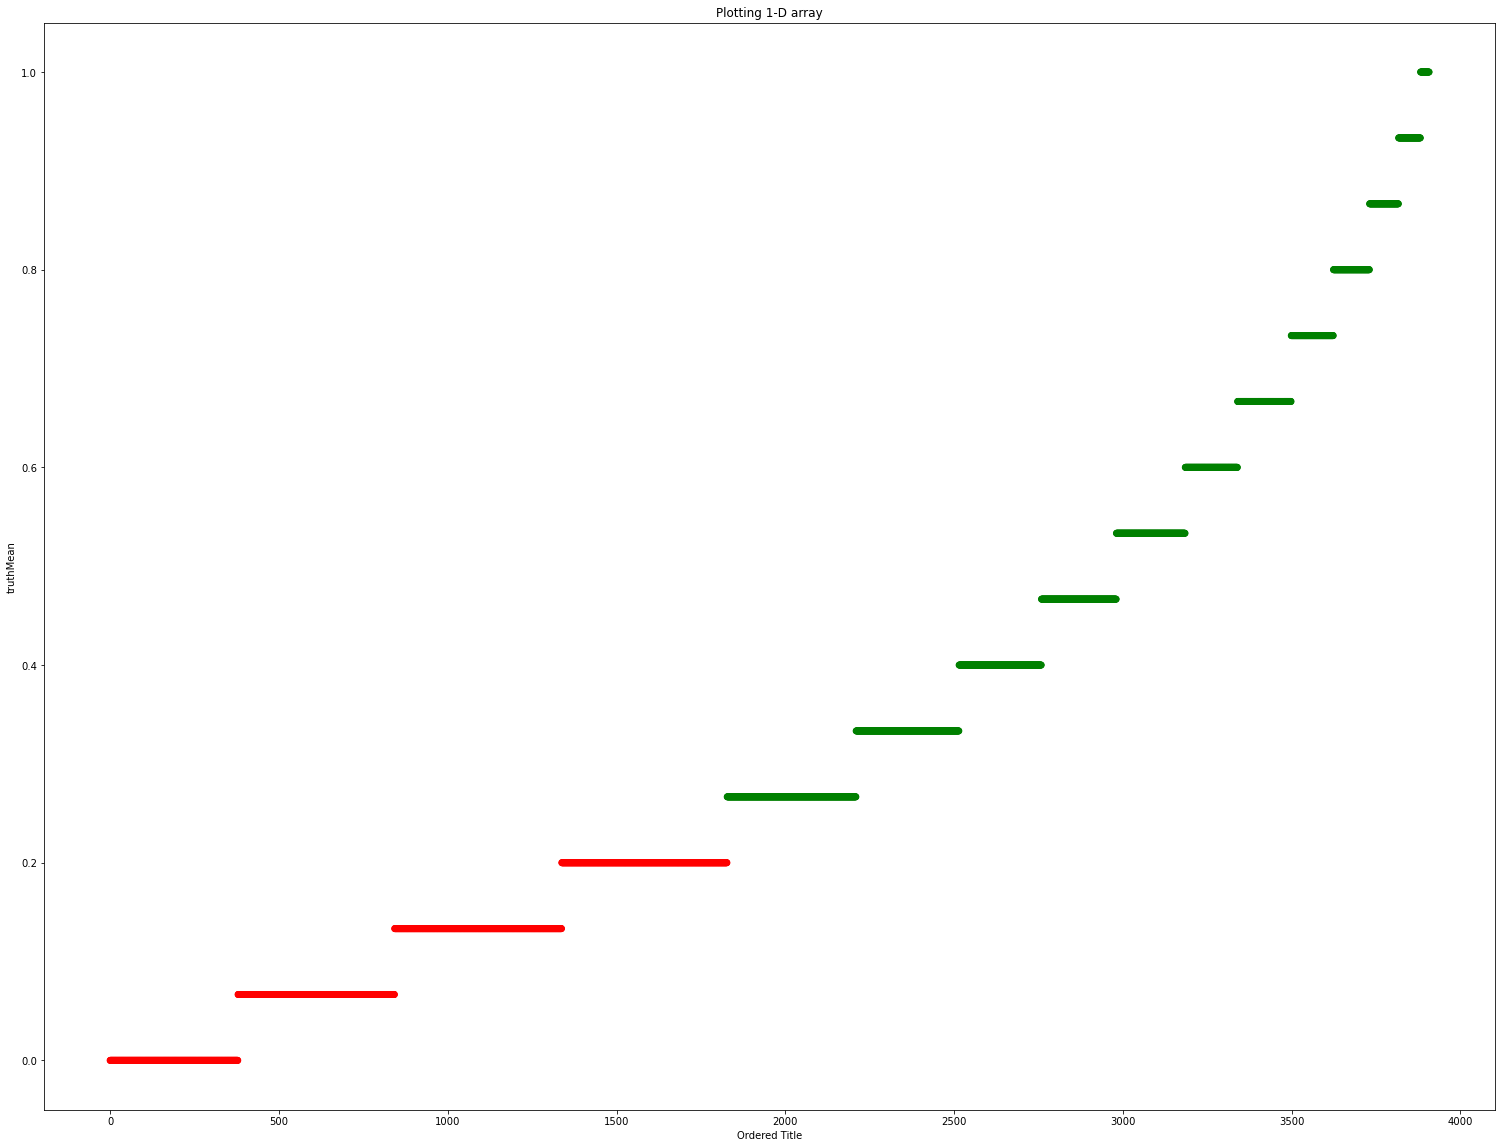

In [44]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction) #LCfraction
x = np.array(range(0, tct.shape[0]))
y = tct[LCfraction]
plt.scatter(x, y, c = color, marker = "o", label = "Array elements")

In [45]:
tct

,postText,id,targetTitle,targetDescription,truthMean,input_ids,attention_mask,label,labelC
0,New tool lets you customize what kinds of onli...,807030514049761280,You may soon be able to pick and choose the on...,The Rubicon Project's new tool lets you custom...,0.0,"[0, 757, 2]","[1, 1, 1]",0,0
3386,Stephen Hawking is being sent to space,843757942952353792,Stephen Hawking will travel to space on board ...,Stephen Hawking is going to go to space. The c...,0.0,"[0, 757, 2]","[1, 1, 1]",0,0
2555,Sarita Devi won her first pro bout by unanimou...,826014658549129216,Sarita Devi Announces Arrival On The Big Stage...,She beat Zsofia Bedo of Hungary.,0.0,"[0, 757, 2]","[1, 1, 1]",0,0
1073,This is what #Aleppo looked like before the wa...,810627817029386240,This is what Aleppo looked like before the war,What the city looked like before the Syrian ci...,0.0,"[0, 757, 2]","[1, 1, 1]",0,0
2520,"In Mr. Pence’s new D.C. neighborhood, not exac...",805220588730118144,"In Mr. Pence’s new D.C. neighborhood, not exac...","In silent protest, residents hoisted gay pride...",0.0,"[0, 757, 2]","[1, 1, 1]",0,0
...,...,...,...,...,...,...,...,...,...
3492,Analysis: MLB spring training is unnecessarily...,831229223507546112,MLB spring training is unnecessarily long. Bla...,"Position players don't need most of it, and te...",1.0,"[0, 805, 2]","[1, 1, 1]",1,1
174,"Michel Roux Jr, here’s a recipe for tipping | ...",809827201344475136,"Michel Roux Jr, here’s a recipe for tipping",His Le Gavroche restaurant has criminally unde...,1.0,"[0, 805, 2]","[1, 1, 1]",1,1
735,People are totally obsessed with this dad send...,816668016234688512,People Are Totally Obsessed With This Dad Send...,,1.0,"[0, 805, 2]","[1, 1, 1]",1,1
2973,"Ariana Grande has a mini ""Victorious"" reunion ...",848998567754813440,Ariana Grande Has a Mini 'Victorious' Reunion ...,Ariana Grande was feeling pretty Victorious at...,1.0,"[0, 805, 2]","[1, 1, 1]",1,1


In [46]:
tct["labelC"].describe()

count    3908.000000
mean        0.532242
std         0.499023
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: labelC, dtype: float64

In [47]:
tct.corr()

,id,truthMean,label,labelC
id,1.000000,0.015939,0.004216,0.004216
truthMean,0.015939,1.000000,0.787872,0.787872
label,0.004216,0.787872,1.000000,1.000000
labelC,0.004216,0.787872,1.000000,1.000000
